In [1]:
import numpy as np  
import pandas as pd 
from datetime import datetime
from scipy.stats import skew
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax
from sklearn.linear_model import ElasticNetCV, LassoCV, RidgeCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import make_scorer
from sklearn.neighbors import LocalOutlierFactor
from sklearn.linear_model import LinearRegression
from mlxtend.regressor import StackingCVRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.max_columns', 5000)
pd.set_option('display.max_rows', 5000)

/Users/shuozhang/anaconda3/lib/python3.7/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_9.4.1) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
print("Train set size:", train.shape)
print("Test set size:", test.shape)

Train set size: (1460, 81)
Test set size: (1459, 80)


In [54]:
train.dtypes # please look at the data description and see which features have the wrong data type.

Id                 int64
MSSubClass         int64
MSZoning          object
LotFrontage      float64
LotArea            int64
Street            object
Alley             object
LotShape          object
LandContour       object
Utilities         object
LotConfig         object
LandSlope         object
Neighborhood      object
Condition1        object
Condition2        object
BldgType          object
HouseStyle        object
OverallQual        int64
OverallCond        int64
YearBuilt          int64
YearRemodAdd       int64
RoofStyle         object
RoofMatl          object
Exterior1st       object
Exterior2nd       object
MasVnrType        object
MasVnrArea       float64
ExterQual         object
ExterCond         object
Foundation        object
BsmtQual          object
BsmtCond          object
BsmtExposure      object
BsmtFinType1      object
BsmtFinSF1         int64
BsmtFinType2      object
BsmtFinSF2         int64
BsmtUnfSF          int64
TotalBsmtSF        int64
Heating           object


In [55]:
train.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1379.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,46.549315,567.240411,1057.429452,1162.626712,346.992466,5.844521,1515.463699,0.425342,0.057534,1.565068,0.382877,2.866438,1.046575,6.517808,0.613014,1978.506164,1.767123,472.980137,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,161.319273,441.866955,438.705324,386.587738,436.528436,48.623081,525.480383,0.518911,0.238753,0.550916,0.502885,0.815778,0.220338,1.625393,0.644666,24.689725,0.747315,213.804841,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,0.000000,334.000000,0.000000,0.000000,334.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,1900.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,0.000000,223.000000,795.750000,882.000000,0.000000,0.000000,1129.500000,0.000000,0.000000,1.000000,0.000000,2.000000,1.000000,5.000000,0.000000,1961.000000,1.000000,334.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,0.000000,477.500000,991.500000,1087.000000,0.000000,0.000000,1464.000000,0.000000,0.000000,2.000000,0.000000,3.000000,1.000000,6.000000,1.000000,1980.000000,2.000000,480.000000,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,0.000000,808.000000,1298.250000,1391.250000,728.000000,0.000000,1776.750000,1.000000,0.000000,2.000000,1.000000,3.000000,1.000000,7.000000,1.000000,2002.000000,2.000000,576.000000,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1474.000000,2336.000000,6110.000000,4692.000000,2065.000000,572.000000,5642.000000,3.000000,2.000000,3.000000,2.000000,8.000000,3.000000,14.000000,3.000000,2010.000000,4.000000,1418.000000,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


In [3]:
train.isnull().sum()

Id                  0
MSSubClass          0
MSZoning            0
LotFrontage       259
LotArea             0
Street              0
Alley            1369
LotShape            0
LandContour         0
Utilities           0
LotConfig           0
LandSlope           0
Neighborhood        0
Condition1          0
Condition2          0
BldgType            0
HouseStyle          0
OverallQual         0
OverallCond         0
YearBuilt           0
YearRemodAdd        0
RoofStyle           0
RoofMatl            0
Exterior1st         0
Exterior2nd         0
MasVnrType          8
MasVnrArea          8
ExterQual           0
ExterCond           0
Foundation          0
BsmtQual           37
BsmtCond           37
BsmtExposure       38
BsmtFinType1       37
BsmtFinSF1          0
BsmtFinType2       38
BsmtFinSF2          0
BsmtUnfSF           0
TotalBsmtSF         0
Heating             0
HeatingQC           0
CentralAir          0
Electrical          1
1stFlrSF            0
2ndFlrSF            0
LowQualFin

In [56]:
# know your target
train['SalePrice'].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

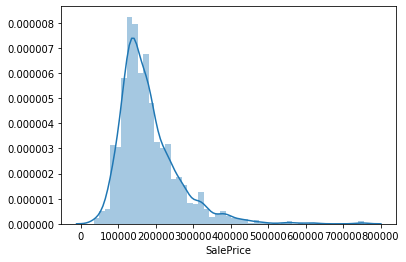

In [57]:
sns.distplot(train['SalePrice']); # not a normal distribution

In [58]:
print("Skewness: %f" % train['SalePrice'].skew()) # For normally distributed data, the skewness should be about 0
print("Kurtosis: %f" % train['SalePrice'].kurt()) # For normally distributed data, the Kurtosis  should be about 0
# please read these material: https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.stats.skew.html
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.kurtosis.html

Skewness: 1.882876
Kurtosis: 6.536282


In [59]:
# We use the numpy fuction log1p which  applies log(1+x) to the sale price
train["SalePrice"] = np.log1p(train["SalePrice"])

#much better
print("Skewness: %f" % train['SalePrice'].skew())
print("Kurtosis: %f" % train['SalePrice'].kurt())

Skewness: 0.121347
Kurtosis: 0.809519


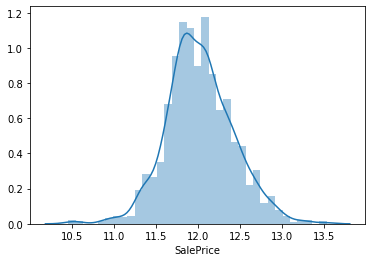

In [60]:
sns.distplot(train['SalePrice']); # close to normal distribution 

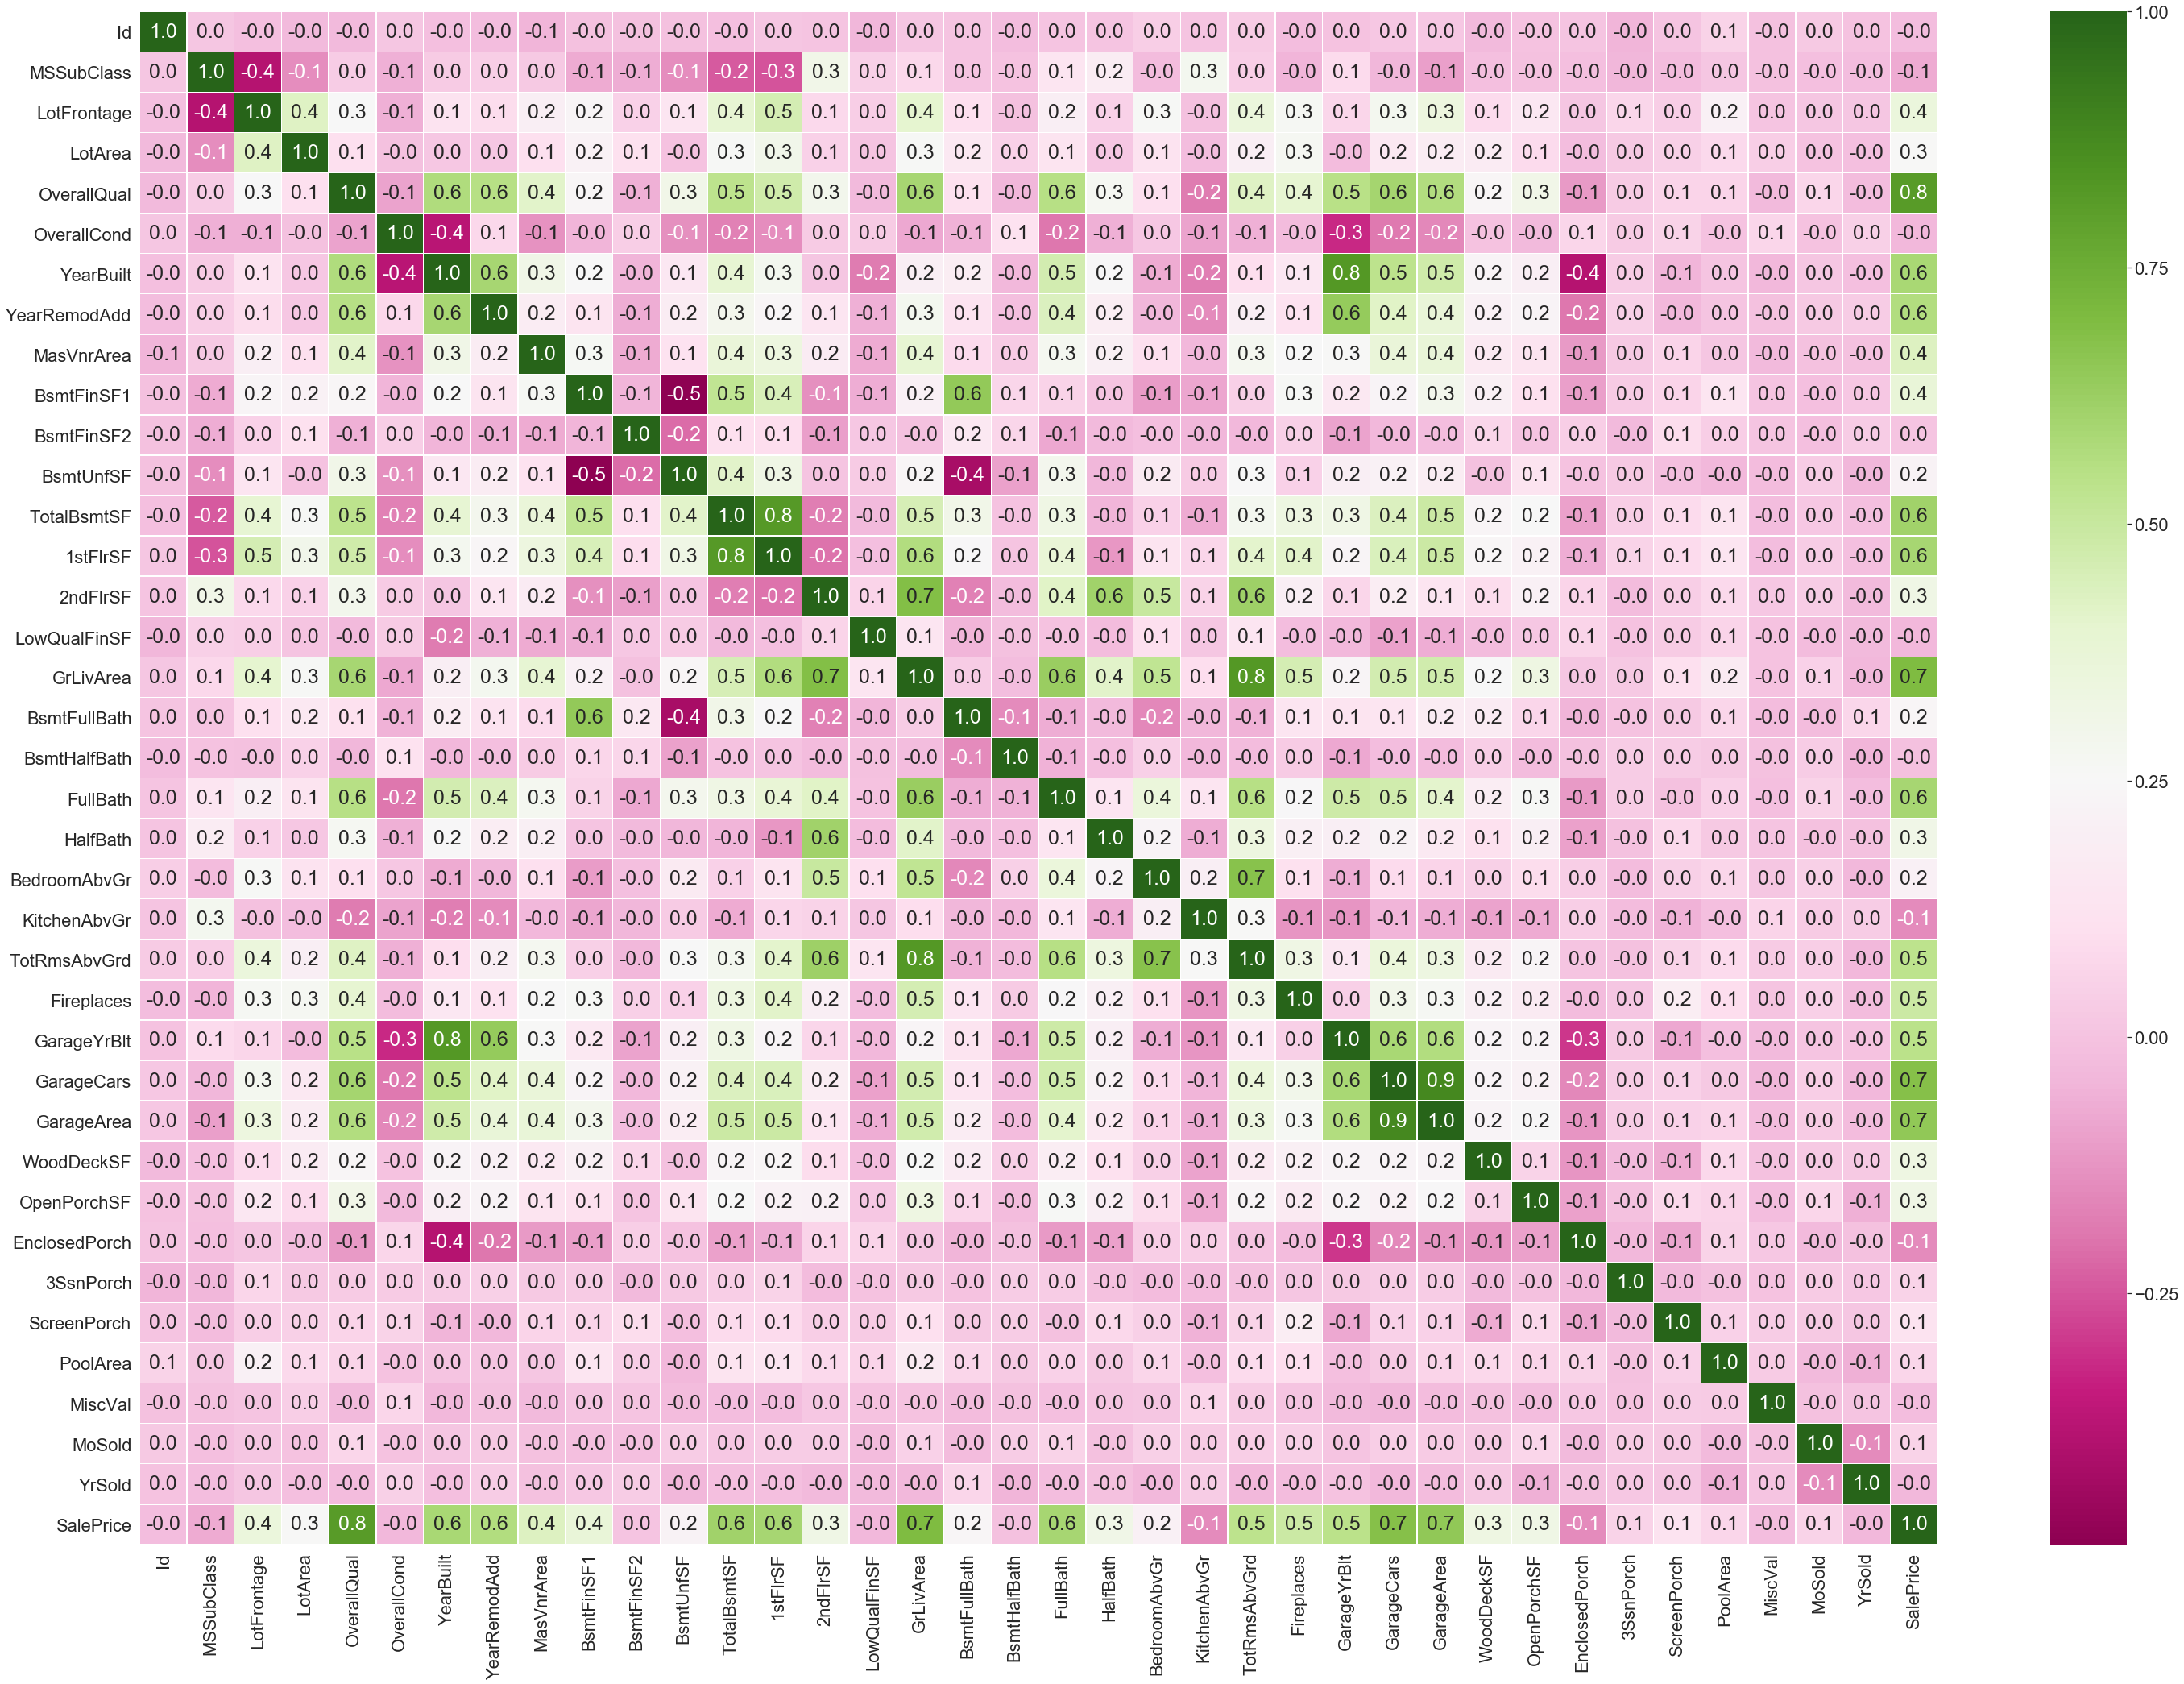

In [61]:
#correlation matrix between the target and all numeric features
# pay attension to the last row 
correlation_train=train.corr()
sns.set(font_scale=2)
plt.figure(figsize = (50,35))
ax = sns.heatmap(correlation_train, annot=True,annot_kws={"size": 25},fmt='.1f',cmap='PiYG', linewidths=.5)

In [62]:
# for predictors, some are high correlated and some are not, that means we can use both linear and non-linear models

In [63]:
# high correlated with saleprice: OverallQual，YearBuilt, YearRemodAdd,
# TotalBsmtSF, 1stFlrSF, GrLiveArea, FullBath, GarageCars, GarageArea
# uncorrelated: Id, OverllCond, BsmtFinSF2,LowQualFinSF, BsmtHalfBath, MiscVal, YrSold

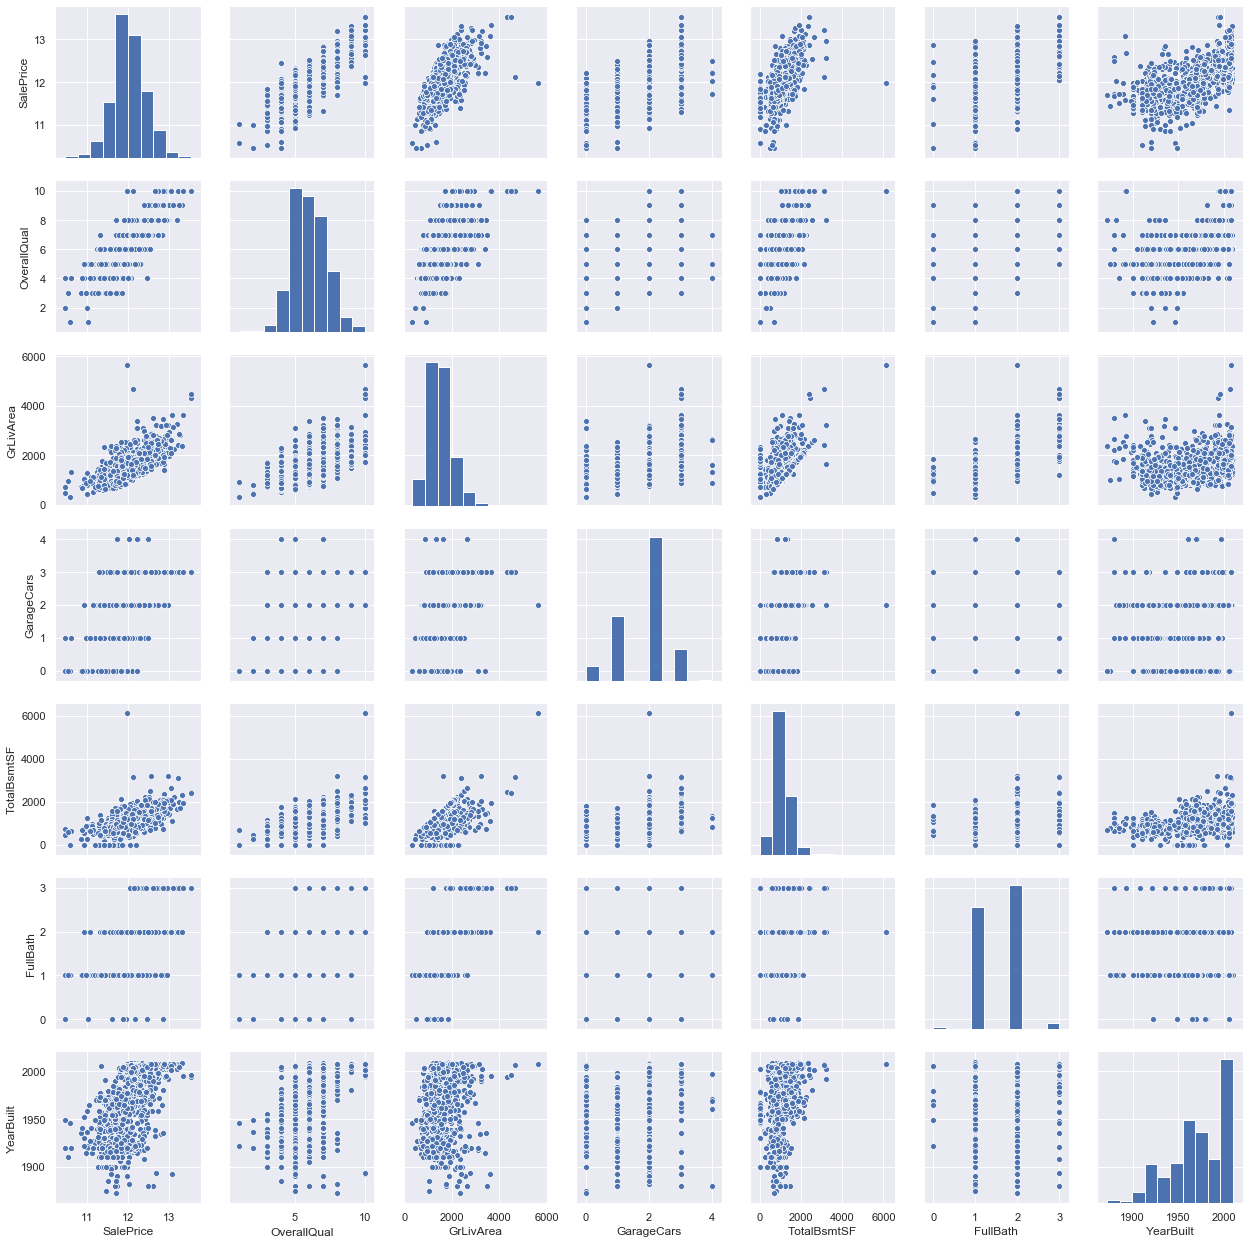

In [64]:
# pick some most correlated features 
sns.set()
cols = ['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF', 'FullBath', 'YearBuilt']
sns.pairplot(train[cols], size = 2.5)
plt.show()
# you can make more plots

In [ ]:
# do the imputation for the training data set before detecting outliners.

In [ ]:
train_copy=train.copy()

In [ ]:
#2. fill na by groupby
train_copy['LotFrontage'] = train_copy.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))
# median value of lotfrontage of each Neighborhood

#4. fillna with 0,these houses have no features
for col in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
    train_copy[col] = train_copy[col].fillna(0)
    
numeric_features=['LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt',
                  'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF',
                  'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea',
                  'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr',
                  'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt',
                  'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
                  'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal']
#6. others: fill na with 0 for numeric features and none for categorical features
train_copy[numeric_features] = train_copy[numeric_features].apply(lambda x: x.fillna(0)) 

In [65]:
#automatic outlier detecting
# x is numeric feature
# y is the target
def detect_outliers(x, y, top=5, plot=True):
    lof = LocalOutlierFactor(n_neighbors=40, contamination=0.1) # Unsupervised Outlier Detection using Local Outlier Factor 
    x_ =np.array(x).reshape(-1,1)
    preds = lof.fit_predict(x_)
    lof_scr = lof.negative_outlier_factor_
    # By comparing the local density of a sample to the local densities of its neighbors, one can identify samples 
    #that have a substantially lower density than their neighbors. These are considered outliers.
    out_idx = pd.Series(lof_scr).sort_values()[:top].index
    if plot:
        f, ax = plt.subplots(figsize=(9, 6))
        plt.scatter(x=x, y=y, c=np.exp(lof_scr), cmap='RdBu')
    return out_idx
# read the material: https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.LocalOutlierFactor.html

In [ ]:
for fea in numeric_features:
    outs = detect_outliers(train_copy[fea],train_copy['SalePrice'],top=5)
    print(outs)

Int64Index([1298, 523, 1182, 691, 533], dtype='int64')

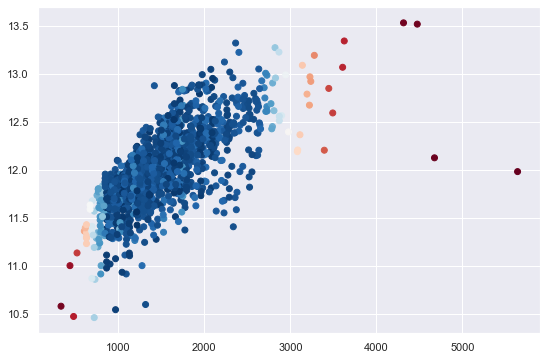

In [66]:
outs = detect_outliers(train_copy['GrLivArea'],train_copy['SalePrice'],top=5) #got 1298,523
outs

Int64Index([185, 170, 635, 1009, 88], dtype='int64')

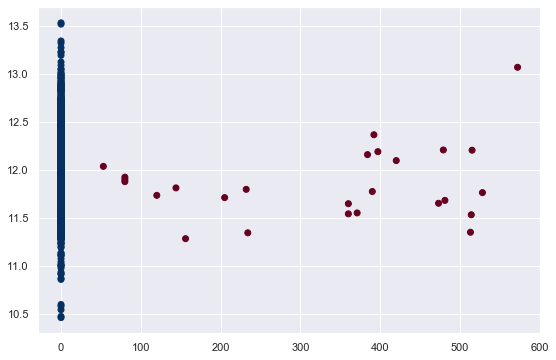

In [67]:
outs = detect_outliers(train_copy['LowQualFinSF'],train_copy['SalePrice'],top=5)#got 88
outs

In [68]:
# please look at more columns and find more outliers.

In [69]:
outliers = [30, 88, 462, 523, 632, 1298, 1324]

In [70]:
#delete outliers
train = train.drop(train.index[outliers])
train.shape

(1453, 81)

In [112]:
y = train.SalePrice.reset_index(drop=True) # train target
train_features = train.drop(['SalePrice'], axis=1) # train predictors
test_features = test # test predictors
# combine together for feature engineering
features = pd.concat([train_features, test_features]).reset_index(drop=True)
# Now drop the  'Id' colum since it's unnecessary for  the prediction process.
features.drop(['Id'], axis=1, inplace=True)
print(features.shape)

(2912, 79)


In [72]:
features.dtypes

MSSubClass         int64
MSZoning          object
LotFrontage      float64
LotArea            int64
Street            object
Alley             object
LotShape          object
LandContour       object
Utilities         object
LotConfig         object
LandSlope         object
Neighborhood      object
Condition1        object
Condition2        object
BldgType          object
HouseStyle        object
OverallQual        int64
OverallCond        int64
YearBuilt          int64
YearRemodAdd       int64
RoofStyle         object
RoofMatl          object
Exterior1st       object
Exterior2nd       object
MasVnrType        object
MasVnrArea       float64
ExterQual         object
ExterCond         object
Foundation        object
BsmtQual          object
BsmtCond          object
BsmtExposure      object
BsmtFinType1      object
BsmtFinSF1       float64
BsmtFinType2      object
BsmtFinSF2       float64
BsmtUnfSF        float64
TotalBsmtSF      float64
Heating           object
HeatingQC         object


In [73]:
# some numeric features should be categorical 
features['MSSubClass'] = features['MSSubClass'].apply(str)
features['YrSold'] = features['YrSold'].astype(str)
features['MoSold'] = features['MoSold'].astype(str)

In [74]:
numeric_features = features.dtypes[features.dtypes != 'object'].index
print(numeric_features)
print(len(numeric_features)) #33
category_features = features.dtypes[features.dtypes == 'object'].index
print(category_features)
print(len(category_features)) #46

Index(['LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt',
       'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF',
       'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea',
       'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr',
       'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt',
       'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal'],
      dtype='object')
33
Index(['MSSubClass', 'MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour',
       'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1',
       'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl',
       'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond',
       'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1',
       'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical',
   

In [75]:
# missing values
features.isnull().sum()

MSSubClass          0
MSZoning            4
LotFrontage       486
LotArea             0
Street              0
Alley            2715
LotShape            0
LandContour         0
Utilities           2
LotConfig           0
LandSlope           0
Neighborhood        0
Condition1          0
Condition2          0
BldgType            0
HouseStyle          0
OverallQual         0
OverallCond         0
YearBuilt           0
YearRemodAdd        0
RoofStyle           0
RoofMatl            0
Exterior1st         1
Exterior2nd         1
MasVnrType         24
MasVnrArea         23
ExterQual           0
ExterCond           0
Foundation          0
BsmtQual           81
BsmtCond           82
BsmtExposure       82
BsmtFinType1       79
BsmtFinSF1          1
BsmtFinType2       80
BsmtFinSF2          1
BsmtUnfSF           1
TotalBsmtSF         1
Heating             0
HeatingQC           0
CentralAir          0
Electrical          1
1stFlrSF            0
2ndFlrSF            0
LowQualFinSF        0
GrLivArea 

In [76]:
all_data_na = (features.isnull().sum() / len(features)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)[:30]
missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})
missing_data

,Missing Ratio
PoolQC,99.690934
MiscFeature,96.394231
Alley,93.234890
Fence,80.494505
FireplaceQu,48.695055
LotFrontage,16.689560
GarageFinish,5.425824
GarageYrBlt,5.425824
GarageQual,5.425824
GarageCond,5.425824


In [ ]:
missing_data.shape

Text(0.5, 1.0, 'Percent missing data by feature')

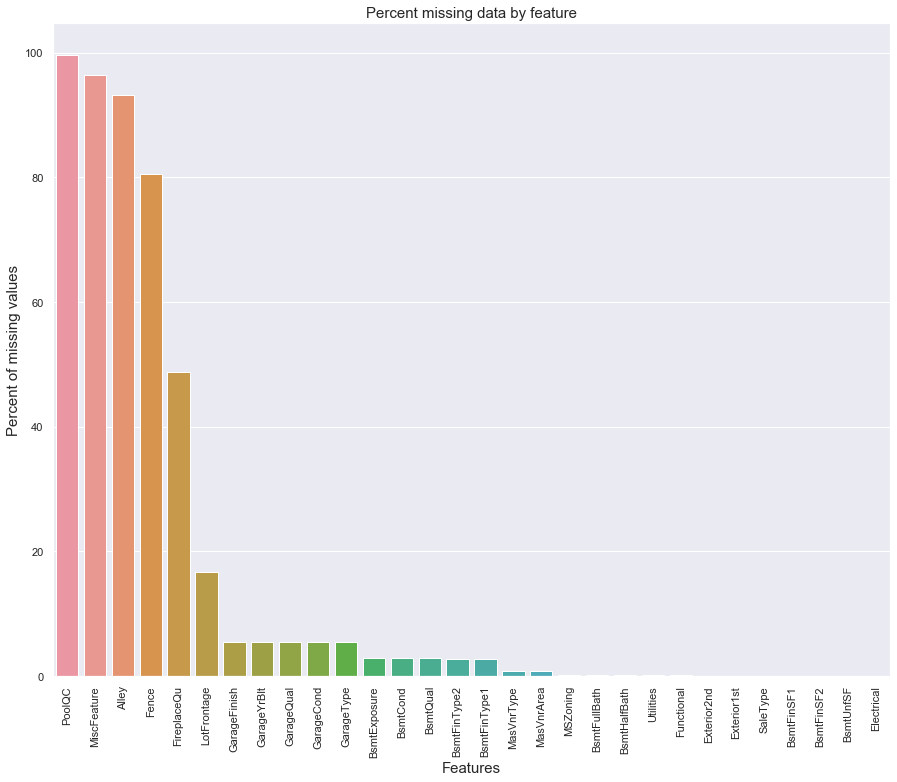

In [77]:
f, ax = plt.subplots(figsize=(15, 12))
plt.xticks(rotation='90')
sns.barplot(x=all_data_na.index, y=all_data_na)
plt.xlabel('Features', fontsize=15)
plt.ylabel('Percent of missing values', fontsize=15)
plt.title('Percent missing data by feature', fontsize=15)

In [78]:
# imputate missingness

In [79]:
#1.fillna with Typical values
features['Functional'] = features['Functional'].fillna('Typ') #Typ	Typical Functionality
features['Electrical'] = features['Electrical'].fillna("SBrkr") #SBrkr	Standard Circuit Breakers & Romex
features['KitchenQual'] = features['KitchenQual'].fillna("TA") #TA	Typical/Average

#2. fill na by groupby
features['MSZoning'] = features.groupby('MSSubClass')['MSZoning'].transform(lambda x: x.fillna(x.mode()[0]))
# most frequent class of mszoning of each MSSubClass
features['LotFrontage'] = features.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))
# median value of lotfrontage of each Neighborhood

#3. fillna with new type: ‘None’, these houses have no features
features["PoolQC"] = features["PoolQC"].fillna("None") 
for col in ['GarageType', 'GarageFinish', 'GarageQual', 'GarageCond']:
    features[col] = features[col].fillna('None')
for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
    features[col] = features[col].fillna('None')

#4. fillna with 0,these houses have no features
for col in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
    features[col] = features[col].fillna(0)

#5. fill na with the most frequnt class
features['Exterior1st'] = features['Exterior1st'].fillna(features['Exterior1st'].mode()[0]) 
features['Exterior2nd'] = features['Exterior2nd'].fillna(features['Exterior2nd'].mode()[0])
features['SaleType'] = features['SaleType'].fillna(features['SaleType'].mode()[0])

#6. others: fill na with 0 for numeric features and none for categorical features
features[numeric_features] = features[numeric_features].apply(
            lambda x: x.fillna(0)) 
features[category_features] = features[category_features].apply(
            lambda x: x.fillna('None')) 

In [80]:
features.isnull().sum()

MSSubClass       0
MSZoning         0
LotFrontage      0
LotArea          0
Street           0
Alley            0
LotShape         0
LandContour      0
Utilities        0
LotConfig        0
LandSlope        0
Neighborhood     0
Condition1       0
Condition2       0
BldgType         0
HouseStyle       0
OverallQual      0
OverallCond      0
YearBuilt        0
YearRemodAdd     0
RoofStyle        0
RoofMatl         0
Exterior1st      0
Exterior2nd      0
MasVnrType       0
MasVnrArea       0
ExterQual        0
ExterCond        0
Foundation       0
BsmtQual         0
BsmtCond         0
BsmtExposure     0
BsmtFinType1     0
BsmtFinSF1       0
BsmtFinType2     0
BsmtFinSF2       0
BsmtUnfSF        0
TotalBsmtSF      0
Heating          0
HeatingQC        0
CentralAir       0
Electrical       0
1stFlrSF         0
2ndFlrSF         0
LowQualFinSF     0
GrLivArea        0
BsmtFullBath     0
BsmtHalfBath     0
FullBath         0
HalfBath         0
BedroomAbvGr     0
KitchenAbvGr     0
KitchenQual 

In [81]:
# please plot the distribution of all numeric features to see whether they are normally distributed.

In [82]:
#data transformation of numeric features
skew_features = features[numeric_features].apply(lambda x: skew(x)).sort_values(ascending=False)
skew_features

MiscVal          21.920854
PoolArea         17.673354
LotArea          13.099125
LowQualFinSF     12.391544
3SsnPorch        11.362112
KitchenAbvGr      4.296287
BsmtFinSF2        4.145924
EnclosedPorch     4.029556
ScreenPorch       3.941117
BsmtHalfBath      3.925998
MasVnrArea        2.624575
OpenPorchSF       2.527454
WoodDeckSF        1.844011
1stFlrSF          1.259015
LotFrontage       1.105058
GrLivArea         1.068478
BsmtFinSF1        0.980559
BsmtUnfSF         0.919505
2ndFlrSF          0.860245
TotRmsAbvGrd      0.747869
Fireplaces        0.726054
HalfBath          0.693943
TotalBsmtSF       0.672246
BsmtFullBath      0.619682
OverallCond       0.578748
BedroomAbvGr      0.325821
GarageArea        0.217763
OverallQual       0.191839
FullBath          0.164972
GarageCars       -0.219219
YearRemodAdd     -0.451505
YearBuilt        -0.600202
GarageYrBlt      -3.915227
dtype: float64

In [83]:
high_skew = skew_features[skew_features > 0.15]
skew_index = high_skew.index

In [84]:
high_skew 

MiscVal          21.920854
PoolArea         17.673354
LotArea          13.099125
LowQualFinSF     12.391544
3SsnPorch        11.362112
KitchenAbvGr      4.296287
BsmtFinSF2        4.145924
EnclosedPorch     4.029556
ScreenPorch       3.941117
BsmtHalfBath      3.925998
MasVnrArea        2.624575
OpenPorchSF       2.527454
WoodDeckSF        1.844011
1stFlrSF          1.259015
LotFrontage       1.105058
GrLivArea         1.068478
BsmtFinSF1        0.980559
BsmtUnfSF         0.919505
2ndFlrSF          0.860245
TotRmsAbvGrd      0.747869
Fireplaces        0.726054
HalfBath          0.693943
TotalBsmtSF       0.672246
BsmtFullBath      0.619682
OverallCond       0.578748
BedroomAbvGr      0.325821
GarageArea        0.217763
OverallQual       0.191839
FullBath          0.164972
dtype: float64

In [ ]:
high_skew_fea=['MiscVal','PoolArea','LotArea','LowQualFinSF','3SsnPorch','KitchenAbvGr','BsmtFinSF2',
              'EnclosedPorch','ScreenPorch','BsmtHalfBath','MasVnrArea','OpenPorchSF','WoodDeckSF',
              '1stFlrSF','LotFrontage','GrLivArea','BsmtFinSF1','BsmtUnfSF','2ndFlrSF',
              'TotRmsAbvGrd','Fireplaces','HalfBath','TotalBsmtSF','BsmtFullBath','OverallCond',
              'BedroomAbvGr','GarageArea','OverallQual','FullBath']
for i in high_skew_fea:
    sns.distplot(features[i])
    plt.show()

In [85]:
# box cox transformation: force to normal distribution
# Compute the Box-Cox transformation of 1 + x.
# y = ((1+y)**lmbda - 1) / lmbda  if lmbda != 0
#     log(1+y)                    if lmbda == 0
for i in skew_index:
    features[i] = boxcox1p(features[i], boxcox_normmax(features[i] + 1)) # Compute optimal Box-Cox transform parameter for input data
# read the material: https://docs.scipy.org/doc/scipy/reference/generated/scipy.special.boxcox1p.html
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.boxcox_normmax.html

In [ ]:
high_skew_fea=['MiscVal','PoolArea','LotArea','LowQualFinSF','3SsnPorch','KitchenAbvGr','BsmtFinSF2',
              'EnclosedPorch','ScreenPorch','BsmtHalfBath','MasVnrArea','OpenPorchSF','WoodDeckSF',
              '1stFlrSF','LotFrontage','GrLivArea','BsmtFinSF1','BsmtUnfSF','2ndFlrSF',
              'TotRmsAbvGrd','Fireplaces','HalfBath','TotalBsmtSF','BsmtFullBath','OverallCond',
              'BedroomAbvGr','GarageArea','OverallQual','FullBath']
for i in high_skew_fea:
    sns.distplot(features[i])
    plt.show()

In [86]:
skew_features = features[numeric_features].apply(lambda x: skew(x)).sort_values(ascending=False)
skew_features # lower than before

PoolArea         15.581589
3SsnPorch         8.854291
LowQualFinSF      8.598260
MiscVal           5.233200
BsmtHalfBath      3.775618
KitchenAbvGr      3.774434
ScreenPorch       3.149430
BsmtFinSF2        2.580032
EnclosedPorch     2.156781
MasVnrArea        0.977673
2ndFlrSF          0.894364
WoodDeckSF        0.784470
HalfBath          0.730155
OpenPorchSF       0.620616
BsmtFullBath      0.614203
Fireplaces        0.553661
OverallCond       0.386057
BsmtFinSF1        0.365142
TotalBsmtSF       0.297233
GarageArea        0.199947
FullBath          0.100798
OverallQual       0.061678
LotFrontage       0.059150
BsmtUnfSF         0.053960
TotRmsAbvGrd      0.047121
BedroomAbvGr      0.035975
GrLivArea         0.008794
1stFlrSF         -0.007718
LotArea          -0.138070
GarageCars       -0.219219
YearRemodAdd     -0.451505
YearBuilt        -0.600202
GarageYrBlt      -3.915227
dtype: float64

In [87]:
# what is the distribution of these features after box cox transformation?

In [88]:
# drop some features that have no affect on house price
features = features.drop(['Utilities', 'Street', 'PoolQC',], axis=1) 

In [89]:
# feature engineering: add new features
features['YrBltAndRemod']=features['YearBuilt']+features['YearRemodAdd']
features['TotalSF']=features['TotalBsmtSF'] + features['1stFlrSF'] + features['2ndFlrSF']

features['Total_sqr_footage'] = (features['BsmtFinSF1'] + features['BsmtFinSF2'] +
                                 features['1stFlrSF'] + features['2ndFlrSF'])

features['Total_Bathrooms'] = (features['FullBath'] + (0.5 * features['HalfBath']) +
                               features['BsmtFullBath'] + (0.5 * features['BsmtHalfBath']))

features['Total_porch_sf'] = (features['OpenPorchSF'] + features['3SsnPorch'] +
                              features['EnclosedPorch'] + features['ScreenPorch'] +
                              features['WoodDeckSF'])

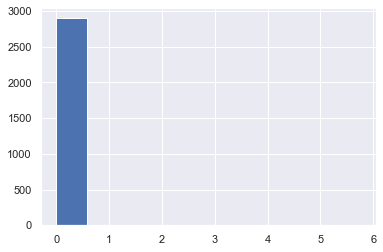

In [90]:
plt.hist(features['PoolArea'])
plt.show()

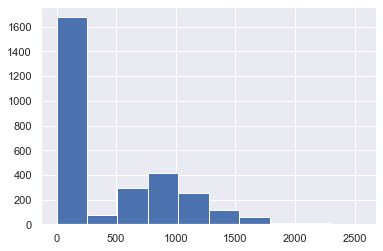

In [91]:
plt.hist(features['2ndFlrSF'])
plt.show()

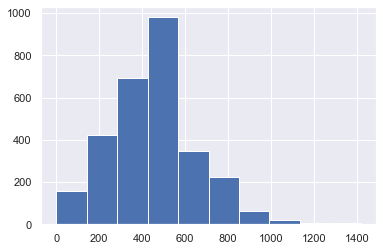

In [92]:
plt.hist(features['GarageArea'])
plt.show()

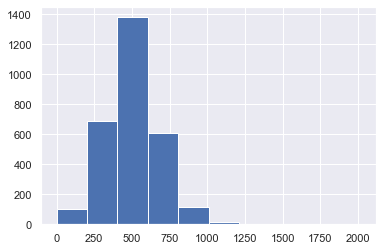

In [93]:
plt.hist(features['TotalBsmtSF'])
plt.show()

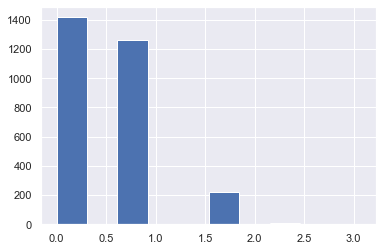

In [94]:
plt.hist(features['Fireplaces'])
plt.show()

In [95]:
# add more features
features['haspool'] = features['PoolArea'].apply(lambda x: 1 if x > 0 else 0)
features['has2ndfloor'] = features['2ndFlrSF'].apply(lambda x: 1 if x > 0 else 0)
features['hasgarage'] = features['GarageArea'].apply(lambda x: 1 if x > 0 else 0)
features['hasbsmt'] = features['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0)
features['hasfireplace'] = features['Fireplaces'].apply(lambda x: 1 if x > 0 else 0)

In [96]:
# change categorical features to dummy variables
print("before get_dummies:",features.shape)
final_features = pd.get_dummies(features).reset_index(drop=True)
print("after get_dummies:",final_features.shape)

before get_dummies: (2912, 86)
after get_dummies: (2912, 333)


In [97]:
X = final_features.iloc[:len(y), :]	
X_sub = final_features.iloc[len(y):, :]
print("after get_dummies, the dataset size:",'X', X.shape, 'y', y.shape, 'X_sub', X_sub.shape)

after get_dummies, the dataset size: X (1453, 333) y (1453,) X_sub (1459, 333)


In [98]:
# delete feaures that almost has one single value
overfit = []
for i in X.columns:
    counts = X[i].value_counts()
    zeros = counts.iloc[0]
    if zeros / len(X) * 100 > 99.94:
        overfit.append(i)

In [99]:
overfit

['MSSubClass_150']

In [100]:
X['MSSubClass_150'].value_counts()

0    1453
Name: MSSubClass_150, dtype: int64

In [101]:
X['MSZoning_C (all)'].value_counts()

0    1445
1       8
Name: MSZoning_C (all), dtype: int64

In [102]:
overfit.append('MSZoning_C (all)')

X = X.drop(overfit, axis=1).copy()
X_sub = X_sub.drop(overfit, axis=1).copy()

print('X', X.shape, 'y', y.shape, 'X_sub', X_sub.shape)

X (1453, 331) y (1453,) X_sub (1459, 331)


In [48]:
# save the result

In [103]:
X.head()

,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,YrBltAndRemod,TotalSF,Total_sqr_footage,Total_Bathrooms,Total_porch_sf,haspool,has2ndfloor,hasgarage,hasbsmt,hasfireplace,MSSubClass_120,MSSubClass_160,MSSubClass_180,MSSubClass_190,MSSubClass_20,MSSubClass_30,MSSubClass_40,MSSubClass_45,MSSubClass_50,MSSubClass_60,MSSubClass_70,MSSubClass_75,MSSubClass_80,MSSubClass_85,MSSubClass_90,MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,Alley_Grvl,Alley_None,Alley_Pave,LotShape_IR1,LotShape_IR2,LotShape_IR3,LotShape_Reg,LandContour_Bnk,LandContour_HLS,LandContour_Low,LandContour_Lvl,LotConfig_Corner,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,LandSlope_Gtl,LandSlope_Mod,LandSlope_Sev,Neighborhood_Blmngtn,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,Condition1_Artery,Condition1_Feedr,Condition1_Norm,Condition1_PosA,Condition1_PosN,Condition1_RRAe,Condition1_RRAn,Condition1_RRNe,Condition1_RRNn,Condition2_Artery,Condition2_Feedr,Condition2_Norm,Condition2_PosA,Condition2_PosN,Condition2_RRAe,Condition2_RRAn,Condition2_RRNn,BldgType_1Fam,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE,HouseStyle_1.5Fin,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,RoofStyle_Flat,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,RoofMatl_CompShg,RoofMatl_Membran,RoofMatl_Metal,RoofMatl_Roll,RoofMatl_Tar&Grv,RoofMatl_WdShake,RoofMatl_WdShngl,Exterior1st_AsbShng,Exterior1st_AsphShn,Exterior1st_BrkComm,Exterior1st_BrkFace,Exterior1st_CBlock,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_ImStucc,Exterior1st_MetalSd,Exterior1st_Plywood,Exterior1st_Stone,Exterior1st_Stucco,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior1st_WdShing,Exterior2nd_AsbShng,Exterior2nd_AsphShn,Exterior2nd_Brk Cmn,Exterior2nd_BrkFace,Exterior2nd_CBlock,Exterior2nd_CmentBd,Exterior2nd_HdBoard,Exterior2nd_ImStucc,Exterior2nd_MetalSd,Exterior2nd_Other,Exterior2nd_Plywood,Exterior2nd_Stone,Exterior2nd_Stucco,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Exterior2nd_Wd Shng,MasVnrType_BrkCmn,MasVnrType_BrkFace,MasVnrType_None,MasVnrType_Stone,ExterQual_Ex,ExterQual_Fa,ExterQual_Gd,ExterQual_TA,ExterCond_Ex,ExterCond_Fa,ExterCond_Gd,ExterCond_Po,ExterCond_TA,Foundation_BrkTil,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,BsmtQual_Ex,BsmtQual_Fa,BsmtQual_Gd,BsmtQual_None,BsmtQual_TA,BsmtCond_Fa,BsmtCond_Gd,BsmtCond_None,BsmtCond_Po,BsmtCond_TA,BsmtExposure_Av,BsmtExposure_Gd,BsmtExposure_Mn,BsmtExposure_No,BsmtExposure_None,BsmtFinType1_ALQ,BsmtFinType1_BLQ,BsmtFinType1_GLQ,BsmtFinType1_LwQ,BsmtFinType1_None,BsmtFinType1_Rec,BsmtFinType1_Unf,BsmtFinType2_ALQ,BsmtFinType2_BLQ,BsmtFinType2_GLQ,BsmtFinType2_LwQ,BsmtFinType2_None,BsmtFinType2_Rec,BsmtFinType2_Unf,Heating_Floor,Heating_GasA,Heating_GasW,Heating_Grav,Heating_OthW,Heating_Wall,HeatingQC_Ex,HeatingQC_Fa,HeatingQC_Gd,HeatingQC_Po,HeatingQC_TA,CentralAir_N,CentralAir_Y,Electrical_FuseA,Electrical_FuseF,Electrical_FuseP,Electrical_Mix,Electrical_SBrkr,KitchenQual_Ex,KitchenQual_Fa,KitchenQual_Gd,KitchenQual_TA,Functional_Maj1,Functional_Maj2,Functional_Min1,Functional_Min2,Functional_Mod,Functional_Sev,Fu

In [106]:
X.to_csv('train_features.csv', index=False)

In [105]:
X_sub.head()

,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,YrBltAndRemod,TotalSF,Total_sqr_footage,Total_Bathrooms,Total_porch_sf,haspool,has2ndfloor,hasgarage,hasbsmt,hasfireplace,MSSubClass_120,MSSubClass_160,MSSubClass_180,MSSubClass_190,MSSubClass_20,MSSubClass_30,MSSubClass_40,MSSubClass_45,MSSubClass_50,MSSubClass_60,MSSubClass_70,MSSubClass_75,MSSubClass_80,MSSubClass_85,MSSubClass_90,MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,Alley_Grvl,Alley_None,Alley_Pave,LotShape_IR1,LotShape_IR2,LotShape_IR3,LotShape_Reg,LandContour_Bnk,LandContour_HLS,LandContour_Low,LandContour_Lvl,LotConfig_Corner,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,LandSlope_Gtl,LandSlope_Mod,LandSlope_Sev,Neighborhood_Blmngtn,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,Condition1_Artery,Condition1_Feedr,Condition1_Norm,Condition1_PosA,Condition1_PosN,Condition1_RRAe,Condition1_RRAn,Condition1_RRNe,Condition1_RRNn,Condition2_Artery,Condition2_Feedr,Condition2_Norm,Condition2_PosA,Condition2_PosN,Condition2_RRAe,Condition2_RRAn,Condition2_RRNn,BldgType_1Fam,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE,HouseStyle_1.5Fin,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,RoofStyle_Flat,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,RoofMatl_CompShg,RoofMatl_Membran,RoofMatl_Metal,RoofMatl_Roll,RoofMatl_Tar&Grv,RoofMatl_WdShake,RoofMatl_WdShngl,Exterior1st_AsbShng,Exterior1st_AsphShn,Exterior1st_BrkComm,Exterior1st_BrkFace,Exterior1st_CBlock,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_ImStucc,Exterior1st_MetalSd,Exterior1st_Plywood,Exterior1st_Stone,Exterior1st_Stucco,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior1st_WdShing,Exterior2nd_AsbShng,Exterior2nd_AsphShn,Exterior2nd_Brk Cmn,Exterior2nd_BrkFace,Exterior2nd_CBlock,Exterior2nd_CmentBd,Exterior2nd_HdBoard,Exterior2nd_ImStucc,Exterior2nd_MetalSd,Exterior2nd_Other,Exterior2nd_Plywood,Exterior2nd_Stone,Exterior2nd_Stucco,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Exterior2nd_Wd Shng,MasVnrType_BrkCmn,MasVnrType_BrkFace,MasVnrType_None,MasVnrType_Stone,ExterQual_Ex,ExterQual_Fa,ExterQual_Gd,ExterQual_TA,ExterCond_Ex,ExterCond_Fa,ExterCond_Gd,ExterCond_Po,ExterCond_TA,Foundation_BrkTil,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,BsmtQual_Ex,BsmtQual_Fa,BsmtQual_Gd,BsmtQual_None,BsmtQual_TA,BsmtCond_Fa,BsmtCond_Gd,BsmtCond_None,BsmtCond_Po,BsmtCond_TA,BsmtExposure_Av,BsmtExposure_Gd,BsmtExposure_Mn,BsmtExposure_No,BsmtExposure_None,BsmtFinType1_ALQ,BsmtFinType1_BLQ,BsmtFinType1_GLQ,BsmtFinType1_LwQ,BsmtFinType1_None,BsmtFinType1_Rec,BsmtFinType1_Unf,BsmtFinType2_ALQ,BsmtFinType2_BLQ,BsmtFinType2_GLQ,BsmtFinType2_LwQ,BsmtFinType2_None,BsmtFinType2_Rec,BsmtFinType2_Unf,Heating_Floor,Heating_GasA,Heating_GasW,Heating_Grav,Heating_OthW,Heating_Wall,HeatingQC_Ex,HeatingQC_Fa,HeatingQC_Gd,HeatingQC_Po,HeatingQC_TA,CentralAir_N,CentralAir_Y,Electrical_FuseA,Electrical_FuseF,Electrical_FuseP,Electrical_Mix,Electrical_SBrkr,KitchenQual_Ex,KitchenQual_Fa,KitchenQual_Gd,KitchenQual_TA,Functional_Maj1,Functional_Maj2,Functional_Min1,Functional_Min2,Functional_Mod,Functional_Sev,Fu

In [107]:
X_sub.to_csv('test_features.csv', index=False)

In [113]:
y = np.array(y)

In [114]:
y=pd.DataFrame(y, columns=['log1p_saleprice'])

In [115]:
y.head()

,log1p_saleprice
0,12.247699
1,12.109016
2,12.317171
3,11.849405
4,12.429220


In [116]:
y.to_csv('train_target.csv',index=False)